In [27]:
#Setup
import fastbook
fastbook.setup_book()
from fastbook import *
from fastai.vision.widgets import *

In [28]:
key = os.environ.get('AZURE_SEARCH_KEY', 'key')

In [29]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [30]:
results = search_images_bing(key, 'tabby cat')
ims = results.attrgot('content_url')
len(ims)

150

In [31]:
cat_types = "siamese", "ragdoll", "british shorthair", "persian", "maine coon", "scottish fold", "sphynx", "tabby" 
path = Path('cat_breeds')

In [32]:
if not path.exists():
    path.mkdir()
    for o in cat_types:
        dest = (path/o)
        dest.mkdir(exist_ok = True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [33]:
fns = get_image_files(path)
fns

(#1140) [Path('cat_breeds/british shorthair/00000000.jpg'),Path('cat_breeds/british shorthair/00000001.jpg'),Path('cat_breeds/british shorthair/00000002.jpg'),Path('cat_breeds/british shorthair/00000003.jpg'),Path('cat_breeds/british shorthair/00000004.jpg'),Path('cat_breeds/british shorthair/00000005.jpg'),Path('cat_breeds/british shorthair/00000006.jpg'),Path('cat_breeds/british shorthair/00000007.jpg'),Path('cat_breeds/british shorthair/00000008.jpg'),Path('cat_breeds/british shorthair/00000009.jpg')...]

In [34]:
failed = verify_images(fns)
failed

(#0) []

In [35]:
failed.map(Path.unlink);

In [36]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [37]:
dls = cats.dataloaders(path)

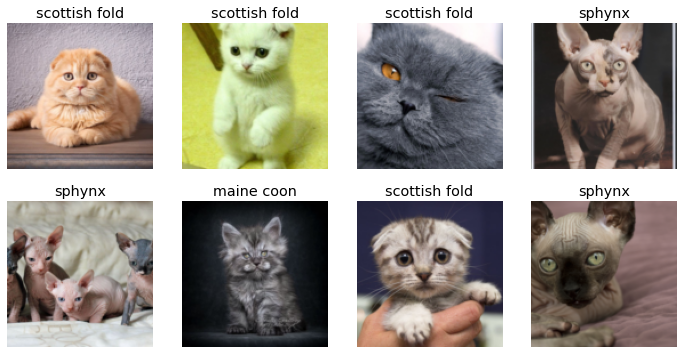

In [38]:
dls.valid.show_batch(max_n = 8, nrows = 2)

In [39]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

In [40]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.356871,0.578408,0.179825,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.873879,0.415520,0.166667,00:11
1,0.716484,0.387092,0.122807,00:10
2,0.578222,0.303144,0.100877,00:10
3,0.501065,0.331520,0.114035,00:10
4,0.424879,0.322712,0.114035,00:10


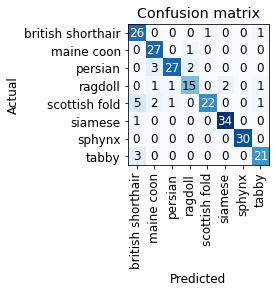

In [41]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

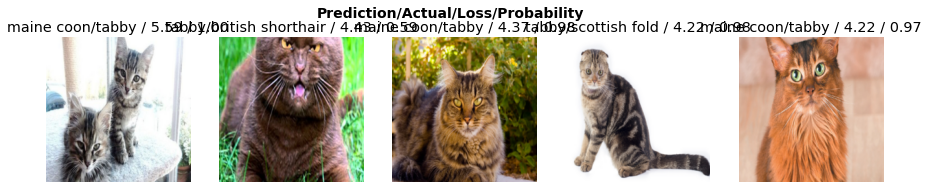

In [57]:
interp.plot_top_losses(5, nrows=1)

In [42]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [44]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

FileNotFoundError: [Errno 2] No such file or directory: 'cat_breeds/scottish fold/00000066.JPG'

In [45]:
learn.export()

In [46]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [47]:
learn_inf = load_learner(path/'export.pkl')

In [48]:
learn_inf.dls.vocab

['british shorthair', 'maine coon', 'persian', 'ragdoll', 'scottish fold', 'siamese', 'sphynx', 'tabby']

In [49]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [53]:
img = PILImage.create(btn_upload.data[-1])

In [54]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [55]:
pred,pred_idx,probs = learn_inf.predict(img)

In [56]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [57]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [58]:
btn_upload = widgets.FileUpload()

In [59]:
display(VBox([widgets.Label('Select your cat!'), 
      btn_upload, btn_run, out_pl, lbl_pred]))

In [ ]:
!